**SETTING DIRECTORY & DOWNLOAD DATASET FROM KAGGLE**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/IDMB-Classfication/

/content/drive/MyDrive/IDMB-Classfication


In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"chophm","key":"1fecc45e8d8d8b8e0737ac9db51f96f4"}'}

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

 82% 21.0M/25.7M [00:00<00:00, 115MB/s] 
100% 25.7M/25.7M [00:00<00:00, 120MB/s]


In [ ]:
!unzip imdb-dataset-of-50k-movie-reviews.zip



Archive:  imdb-dataset-of-50k-movie-reviews.zip
  inflating: IMDB Dataset.csv        


In [3]:
# import libraries

# data manipulation
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# text processing
import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
stopwords = set(stopwords.words('english'))

# pytorch
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader

# sklearn
from sklearn.metrics import classification_report, confusion_matrix

# utils
import os
from tqdm import tqdm
tqdm.pandas()
from collections import Counter

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


**READ DATA FROM FILE**

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/IDMB-Classfication/IMDB Dataset.csv')
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
def transform_label(label):
    return 1 if label == 'positive' else 0

data['label'] = data['sentiment'].progress_apply(transform_label)
data.head()

100%|██████████| 50000/50000 [00:00<00:00, 975796.24it/s]


,review,sentiment,label
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


In [ ]:
data.sentiment.value_counts()


positive    25000
negative    25000
Name: sentiment, dtype: int64

In [ ]:
data['token_length'] = data.review.progress_apply(lambda x: len(x.split()))


100%|██████████| 50000/50000 [00:00<00:00, 98269.88it/s] 


In [ ]:
data_pos = data[data['label'] == 1]
data_pos['token_length'].describe()

count    25000.000000
mean       232.849320
std        177.497046
min         10.000000
25%        125.000000
50%        172.000000
75%        284.000000
max       2470.000000
Name: token_length, dtype: float64

In [ ]:
data_neg = data[data['label'] == 0]
data_neg['token_length'].describe()

count    25000.000000
mean       229.464560
std        164.947795
min          4.000000
25%        128.000000
50%        174.000000
75%        278.000000
max       1522.000000
Name: token_length, dtype: float64

**TEXT CLEANING AND PROCESSING**

In [ ]:
def rm_link(text):
    return re.sub(r'https?://\S+|www\.\S+', '', text)

# handle case like "shut up okay?Im only 10 years old"
# become "shut up okay Im only 10 years old"
def rm_punct2(text):
    # return re.sub(r'[\!\"\#\$\%\&\'\(\)\*\+\,\-\.\/\:\;\<\=\>\?\@\[\\\]\^\_\`\{\|\}\~]', ' ', text)
    return re.sub(r'[\"\#\$\%\&\'\(\)\*\+\/\:\;\<\=\>\@\[\\\]\^\_\`\{\|\}\~]', ' ', text)

def rm_html(text):
    return re.sub(r'<[^>]+>', '', text)

def space_bt_punct(text):
    pattern = r'([.,!?-])'
    s = re.sub(pattern, r' \1 ', text)     # add whitespaces between punctuation
    s = re.sub(r'\s{2,}', ' ', s)        # remove double whitespaces    
    return s

def rm_number(text):
    return re.sub(r'\d+', '', text)

def rm_whitespaces(text):
    return re.sub(r' +', ' ', text)

def rm_nonascii(text):
    return re.sub(r'[^\x00-\x7f]', r'', text)

def rm_emoji(text):
    emojis = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE
    )
    return emojis.sub(r'', text)

def spell_correction(text):
    return re.sub(r'(.)\1+', r'\1\1', text)

def clean_pipeline(text):    
    no_link = rm_link(text)
    no_html = rm_html(no_link)
    space_punct = space_bt_punct(no_html)
    no_punct = rm_punct2(space_punct)
    no_number = rm_number(no_punct)
    no_whitespaces = rm_whitespaces(no_number)
    no_nonasci = rm_nonascii(no_whitespaces)
    no_emoji = rm_emoji(no_nonasci)
    spell_corrected = spell_correction(no_emoji)
    return spell_corrected

In [ ]:
# preprocessing
def tokenize(text):
    return word_tokenize(text)

def rm_stopwords(text):
    return [i for i in text if i not in stopwords]

def lemmatize(text):
    lemmatizer = WordNetLemmatizer()    
    lemmas = [lemmatizer.lemmatize(t) for t in text]
    # make sure lemmas does not contains sotpwords
    return rm_stopwords(lemmas)

def preprocess_pipeline(text):
    tokens = tokenize(text)
    no_stopwords = rm_stopwords(tokens)
    lemmas = lemmatize(no_stopwords)
    return ' '.join(lemmas)

In [ ]:
data['clean'] = data['review'].progress_apply(clean_pipeline)
data['processed'] = data['clean'].progress_apply(preprocess_pipeline)
data.head()

100%|██████████| 50000/50000 [01:46<00:00, 467.44it/s]


,review,sentiment,label,token_length,clean,processed
0,One of the other reviewers has mentioned that ...,positive,1,307,One of the other reviewers has mentioned that ...,One reviewer mentioned watching Oz episode hoo...
1,A wonderful little production. <br /><br />The...,positive,1,162,A wonderful little production . The filming te...,A wonderful little production . The filming te...
2,I thought this was a wonderful way to spend ti...,positive,1,166,I thought this was a wonderful way to spend ti...,I thought wonderful way spend time hot summer ...
3,Basically there's a family where a little boy ...,negative,0,138,Basically there s a family where a little boy ...,Basically family little boy Jake think zombie ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1,230,Petter Mattei s Love in the Time of Money is a...,Petter Mattei Love Time Money visually stunnin...


In [ ]:
data[['processed', 'label']].to_csv('./imdb_processed.csv', index=False, header=True)


**PREPARE DATASET**

In [8]:
# read processed data
data = pd.read_csv('./imdb_processed.csv')
data_predict = pd.read_csv('./final_processing.csv')
for row in data[:2].iterrows():
    print(row[1]['processed'])
    print(f'Label: {row[1]["label"]}')    
    print('\n')

One reviewer mentioned watching Oz episode hooked . They right , exactly happened . The first thing struck Oz brutality unflinching scene violence , set right word GO . Trust , show faint hearted timid . This show pull punch regard drug , sex violence . Its hardcore , classic use word . It called OZ nickname given Oswald Maximum Security State Penitentary . It focus mainly Emerald City , experimental section prison cell glass front face inwards , privacy high agenda . Em City home many . . Aryans , Muslims , gangsta , Latinos , Christians , Italians , Irish . . . . scuffle , death stare , dodgy dealing shady agreement never far away . I would say main appeal show due fact go show dare . Forget pretty picture painted mainstream audience , forget charm , forget romance . . . OZ mess around . The first episode I ever saw struck nasty surreal , I say I ready , I watched , I developed taste Oz , got accustomed high level graphic violence . Not violence , injustice crooked guard sold nickel 

In [9]:
# get all processed reviews
reviews = data.processed.values 
reviews_pr =  data_predict.processed.values
full_word = np.concatenate((reviews, reviews_pr))
print(len(reviews))
# merge into single variable, separated by whitespaces
words = ' '.join(full_word)
# obtain list of words
words = words.split()

# check our list
words[:10]

50000


['One',
 'reviewer',
 'mentioned',
 'watching',
 'Oz',
 'episode',
 'hooked',
 '.',
 'They',
 'right']

In [10]:
# build vocabulary
counter = Counter(words)
vocab = sorted(counter, key=counter.get, reverse=True)
int2word = dict(enumerate(vocab, 1))
int2word[0] = '<PAD>'
word2int = {word: id for id, word in int2word.items()}

In [11]:
# encode words
reviews_enc = [[word2int[word] for word in review.split()] for review in tqdm(reviews)]

# print first-10 words of first 5 reviews
for i in range(5):
    print(len(reviews_enc[i]))

100%|██████████| 50000/50000 [00:01<00:00, 29838.94it/s]

228
109
108
84
160


In [12]:
def pad_features(reviews, pad_id, seq_length=128):
    # features = np.zeros((len(reviews), seq_length), dtype=int)
    features = np.full((len(reviews), seq_length), pad_id, dtype=int)

    for i, row in enumerate(reviews):
        # if seq_length < len(row) then review will be trimmed
        features[i, :len(row)] = np.array(row)[:seq_length]

    return features

seq_length = 256
features = pad_features(reviews_enc, pad_id=word2int['<PAD>'], seq_length=seq_length)

assert len(features) == len(reviews_enc)
assert len(features[0]) == seq_length

features[:10, :10]

array([[  193,  1142,   954,    85,  3196,   233,  3218,     1,   119,
          111],
       [   45,   327,    60,   255,     1,     7,  1333,  1674, 16995,
            4],
       [    3,    95,   327,    28,  1111,    12,   888,  1566,  2650,
            2],
       [ 2421,   132,    60,   244,  2356,    38,   782,  4771,   561,
          870],
       [78122, 12322,  1087,  1840,  7248,  1909,  1137,     6,    44,
            1],
       [ 2809,     4,    12,   361,     5,     2,    17, 43085,     2,
         2653],
       [    3,   189,    20,    10,    21, 12743,  2108, 61754,   145,
         4121],
       [   15,    37,   357,     2,  1258,  3719,   168,    31,  3498,
            1],
       [52918,   990,   429,     6,     3,   187,   754,    85,     6,
            1],
       [   67,    10,   116,  2133,  5085,  2161,    10,     5,     1,
           67]])

In [13]:
# get labels as numpy
labels = data.label.to_numpy()
labels

array([1, 1, 1, ..., 0, 0, 0])

In [14]:
# train test split
train_size = .7     # we will use 80% of whole data as train set
val_size = .5       # and we will use 50% of test set as validation set

# make train set
split_id = int(len(features) * train_size)
train_x, remain_x = features[:split_id], features[split_id:]
train_y, remain_y = labels[:split_id], labels[split_id:]

# make val and test set
split_val_id = int(len(remain_x) * val_size)
val_x, test_x = remain_x[:split_val_id], remain_x[split_val_id:]
val_y, test_y = remain_y[:split_val_id], remain_y[split_val_id:]

# print out the shape
print('Feature Shapes:')
print('===============')
print('Train set: {}'.format(train_x.shape))
print('Validation set: {}'.format(val_x.shape))
print('Test set: {}'.format(test_x.shape))

Feature Shapes:
Train set: (35000, 256)
Validation set: (7500, 256)
Test set: (7500, 256)


In [15]:
# define batch size
batch_size = 128

# create tensor datasets
trainset = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
validset = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
testset = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

# create dataloaders
trainloader = DataLoader(trainset, shuffle=True, batch_size=batch_size)
valloader = DataLoader(validset, shuffle=True, batch_size=batch_size)
testloader = DataLoader(testset, shuffle=True, batch_size=batch_size)

In [ ]:
# check our batches
dataiter = iter(trainloader)
x, y = next(dataiter)

print('Sample batch size: ', x.size())   # batch_size, seq_length
print('Sample batch input: \n', x)
print()
print('Sample label size: ', y.size())   # batch_size
print('Sample label input: \n', y)

Sample batch size:  torch.Size([128, 256])
Sample batch input: 
 tensor([[41691,  1253, 21067,  ...,     0,     0,     0],
        [   15,  6348,   154,  ...,  3402,   562,  3026],
        [    3,    47,     5,  ...,     0,     0,     0],
        ...,
        [23395,    75,     9,  ...,     0,     0,     0],
        [27591,     4, 67895,  ...,   294,  1577,     2],
        [ 1706,  1149,     2,  ...,     0,     0,     0]])

Sample label size:  torch.Size([128])
Sample label input: 
 tensor([0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1,
        0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0,
        1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1,
        0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
        1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1,
        0, 1, 0, 1, 0, 0, 1, 1])


In [4]:
class SentimentModel(nn.Module):
    def __init__(self, vocab_size, output_size, hidden_size=128, embedding_size=400, n_layers=2, dropout=0.2):
        super(SentimentModel, self).__init__()

        # embedding layer is useful to map input into vector representation
        self.embedding = nn.Embedding(vocab_size, embedding_size)

        # LSTM layer preserved by PyTorch library
        self.lstm = nn.LSTM(embedding_size, hidden_size, n_layers, dropout=dropout, batch_first=True)

        # dropout layer
        self.dropout = nn.Dropout(0.3)

        # Linear layer for output
        self.fc = nn.Linear(hidden_size, output_size)

        # Sigmoid layer cz we will have binary classification
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        
        # convert feature to long
        x = x.long()

        # map input to vector
        x = self.embedding(x)

        # pass forward to lstm
        o, _ =  self.lstm(x)

        # get last sequence output
        o = o[:, -1, :]

        # apply dropout and fully connected layer
        o = self.dropout(o)
        o = self.fc(o)

        # sigmoid
        o = self.sigmoid(o)

        return o

In [5]:
# define training device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [17]:
# model hyperparamters
vocab_size = len(word2int)
output_size = 1
embedding_size = 256
hidden_size = 512
n_layers = 2
dropout=0.25

# model initialization
model = SentimentModel(vocab_size, output_size, hidden_size, embedding_size, n_layers, dropout)
print(model)

SentimentModel(
  (embedding): Embedding(133825, 256)
  (lstm): LSTM(256, 512, num_layers=2, batch_first=True, dropout=0.25)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [21]:
# training config
lr = 0.001
criterion = nn.BCELoss() 
optim = Adam(model.parameters(), lr=lr)
grad_clip = 5
epochs = 6
print_every = 1
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'epochs': epochs
}
es_limit = 5

In [ ]:
# train loop
model = model.to(device)

epochloop = tqdm(range(epochs), position=0, desc='Training', leave=True)

# early stop trigger
es_trigger = 0
val_loss_min = torch.inf

for e in epochloop:

    #################
    # training mode #
    #################

    model.train()

    train_loss = 0
    train_acc = 0

    for id, (feature, target) in enumerate(trainloader):
        # add epoch meta info
        epochloop.set_postfix_str(f'Training batch {id}/{len(trainloader)}')

        # move to device
        feature, target = feature.to(device), target.to(device)

        # reset optimizer
        optim.zero_grad()

        # forward pass
        out = model(feature)

        # acc
        predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
        equals = predicted == target
        acc = torch.mean(equals.type(torch.FloatTensor))
        train_acc += acc.item()

        # loss
        loss = criterion(out.squeeze(), target.float())
        train_loss += loss.item()
        loss.backward()

        # clip grad
        nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

        # update optimizer
        optim.step()

        # free some memory
        del feature, target, predicted

    history['train_loss'].append(train_loss / len(trainloader))
    history['train_acc'].append(train_acc / len(trainloader))

    ####################
    # validation model #
    ####################

    model.eval()

    val_loss = 0
    val_acc = 0

    with torch.no_grad():
        for id, (feature, target) in enumerate(valloader):
            # add epoch meta info
            epochloop.set_postfix_str(f'Validation batch {id}/{len(valloader)}')
            
            # move to device
            feature, target = feature.to(device), target.to(device)

            # forward pass
            out = model(feature)

            # acc
            predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
            equals = predicted == target
            acc = torch.mean(equals.type(torch.FloatTensor))
            val_acc += acc.item()

            # loss
            loss = criterion(out.squeeze(), target.float())
            val_loss += loss.item()

            # free some memory
            del feature, target, predicted

        history['val_loss'].append(val_loss / len(valloader))
        history['val_acc'].append(val_acc / len(valloader))

    # reset model mode
    model.train()

    # add epoch meta info
    epochloop.set_postfix_str(f'Val Loss: {val_loss / len(valloader):.3f} | Val Acc: {val_acc / len(valloader):.3f}')

    # print epoch
    if (e+1) % print_every == 0:
        epochloop.write(f'Epoch {e+1}/{epochs} | Train Loss: {train_loss / len(trainloader):.3f} Train Acc: {train_acc / len(trainloader):.3f} | Val Loss: {val_loss / len(valloader):.3f} Val Acc: {val_acc / len(valloader):.3f}')
        epochloop.update()

    # save model if validation loss decrease
    if val_loss / len(valloader) <= val_loss_min:
        torch.save(model.state_dict(), './sentiment_lstm_2.pt')
        val_loss_min = val_loss / len(valloader)
        es_trigger = 0
    else:
        epochloop.write(f'[WARNING] Validation loss did not improved ({val_loss_min:.3f} --> {val_loss / len(valloader):.3f})')
        es_trigger += 1

    # force early stop
    if es_trigger >= es_limit:
        epochloop.write(f'Early stopped at Epoch-{e+1}')
        # update epochs history
        history['epochs'] = e+1
        break

Training:  17%|█▋        | 1/6 [01:12<06:03, 72.69s/it, Val Loss: 0.693 | Val Acc: 0.507]

Epoch 1/6 | Train Loss: 0.694 Train Acc: 0.502 | Val Loss: 0.693 Val Acc: 0.507


Training:  50%|█████     | 3/6 [02:30<02:35, 51.80s/it, Val Loss: 0.692 | Val Acc: 0.507]

Epoch 2/6 | Train Loss: 0.696 Train Acc: 0.510 | Val Loss: 0.692 Val Acc: 0.507


Training:  67%|██████▋   | 4/6 [03:48<02:04, 62.21s/it, Val Loss: 0.692 | Val Acc: 0.514]

Epoch 3/6 | Train Loss: 0.691 Train Acc: 0.515 | Val Loss: 0.692 Val Acc: 0.514


Training: 100%|██████████| 6/6 [05:06<00:00, 52.69s/it, Training batch 0/274]            

Epoch 4/6 | Train Loss: 0.686 Train Acc: 0.525 | Val Loss: 0.694 Val Acc: 0.620
[WARNING] Validation loss did not improved (0.692 --> 0.694)


Training: 7it [06:24, 60.73s/it, Val Loss: 0.553 | Val Acc: 0.754]                       

Epoch 5/6 | Train Loss: 0.566 Train Acc: 0.718 | Val Loss: 0.553 Val Acc: 0.754


Training: 8it [07:42, 66.37s/it, Val Loss: 0.417 | Val Acc: 0.819]

Epoch 6/6 | Train Loss: 0.432 Train Acc: 0.817 | Val Loss: 0.417 Val Acc: 0.819


Training: 100%|██████████| 6/6 [07:42<00:00, 77.16s/it, Val Loss: 0.417 | Val Acc: 0.819]


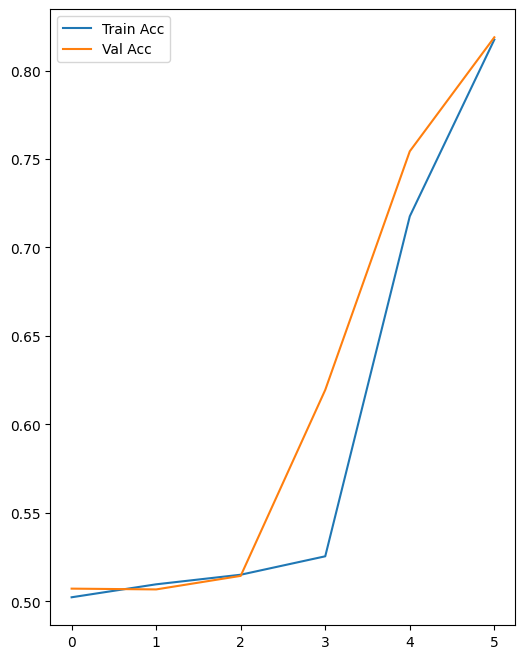

In [ ]:
# plot loss
plt.figure(figsize=(6, 8))
plt.plot(range(history['epochs']), history['train_acc'], label='Train Acc')
plt.plot(range(history['epochs']), history['val_acc'], label='Val Acc')
plt.legend()
plt.show()

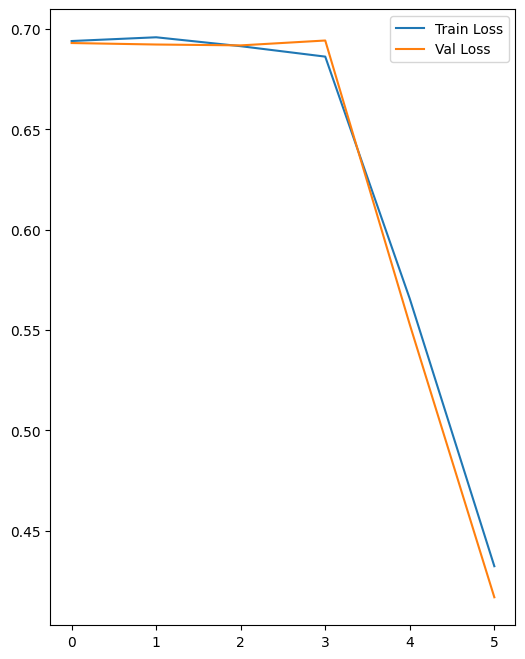

In [ ]:
# plot loss
plt.figure(figsize=(6, 8))
plt.plot(range(history['epochs']), history['train_loss'], label='Train Loss')
plt.plot(range(history['epochs']), history['val_loss'], label='Val Loss')
plt.legend()
plt.show()

In [22]:
model.eval()

# metrics
test_loss = 0
test_acc = 0

all_target = []
all_predicted = []

testloop = tqdm(testloader, leave=True, desc='Inference')
with torch.no_grad():
    for feature, target in testloop:
        feature, target = feature.to(device), target.to(device)
        print(type(feature))
        out = model(feature)
        
        predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
        equals = predicted == target
        acc = torch.mean(equals.type(torch.FloatTensor))
        test_acc += acc.item()

        loss = criterion(out.squeeze(), target.float())
        test_loss += loss.item()

        all_target.extend(target.cpu().numpy())
        all_predicted.extend(predicted.cpu().numpy())

    print(f'Accuracy: {test_acc/len(testloader):.4f}, Loss: {test_loss/len(testloader):.4f}')

Inference:   2%|▏         | 1/59 [00:00<00:07,  7.73it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>


Inference:   7%|▋         | 4/59 [00:00<00:05, 10.32it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


Inference:  10%|█         | 6/59 [00:00<00:04, 11.12it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


Inference:  17%|█▋        | 10/59 [00:00<00:04, 11.84it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


Inference:  20%|██        | 12/59 [00:01<00:03, 12.00it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


Inference:  27%|██▋       | 16/59 [00:01<00:03, 12.13it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


Inference:  31%|███       | 18/59 [00:01<00:03, 12.14it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


Inference:  37%|███▋      | 22/59 [00:01<00:03, 12.13it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


Inference:  41%|████      | 24/59 [00:02<00:02, 12.04it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


Inference:  47%|████▋     | 28/59 [00:02<00:02, 12.08it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


Inference:  51%|█████     | 30/59 [00:02<00:02, 12.10it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


Inference:  58%|█████▊    | 34/59 [00:02<00:02, 12.02it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


Inference:  61%|██████    | 36/59 [00:03<00:01, 11.98it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


Inference:  68%|██████▊   | 40/59 [00:03<00:01, 12.04it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


Inference:  71%|███████   | 42/59 [00:03<00:01, 11.95it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


Inference:  78%|███████▊  | 46/59 [00:03<00:01, 11.96it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


Inference:  81%|████████▏ | 48/59 [00:04<00:00, 11.91it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


Inference:  88%|████████▊ | 52/59 [00:04<00:00, 11.96it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


Inference:  92%|█████████▏| 54/59 [00:04<00:00, 11.99it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


Inference:  98%|█████████▊| 58/59 [00:04<00:00, 11.94it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


Inference: 100%|██████████| 59/59 [00:04<00:00, 11.90it/s]

Accuracy: 0.8145, Loss: 0.4250


**PREDICT DATA FROM CRAWLER**

In [ ]:
checkpoint = torch.load('sentiment_lstm_2.pt')
print(checkpoint)

# model = model.to(device)

In [18]:
model.load_state_dict(checkpoint)


<All keys matched successfully>

In [19]:
model.to(device)

SentimentModel(
  (embedding): Embedding(133825, 256)
  (lstm): LSTM(256, 512, num_layers=2, batch_first=True, dropout=0.25)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
model.eval()
data_pre = pd.read_csv('./final_processing.csv')
i = 0
pre_csv = []
with torch.no_grad():
    for review in tqdm(data_pre['processed']):
        encode = [[word2int[word] for word in review.split()]]
        # print(encode)
        feature = pad_features(encode, pad_id=word2int['<PAD>'], seq_length=seq_length)
        feature = torch.from_numpy(feature)
        i += 1
        feature = feature.to(device)
        pre = model(feature)
        predicted = torch.tensor([1 if i == True else 0 for i in pre > 0.5], device=device)
        str_pre = 'positive' if predicted == torch.tensor([1], device = device) else 'negative'
        # print('Review {}:  '.format(i), str_pre)
        pre_csv.append(
            str_pre
        )
data_pre['predicted'] = pre_csv


100%|██████████| 11207/11207 [02:02<00:00, 91.43it/s]


In [ ]:
data_pre[['film','processed','predicted']].to_csv('./final_predicted.csv', index = False, header = True)

In [ ]:
predict_csv = pd.read_csv('./final_predicted.csv')
predict_csv['film'].value_counts().sort_index()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

films = predict_csv[(predict_csv["predicted"] == "positive")].groupby("film").count()
# print(films.predicted)

ne_films = predict_csv[predict_csv["predicted"] == "negative"].groupby("film").count()
# print(ne_films.predicted)

merge = pd.merge(films, ne_films, on = "film")
merge.head()

,processed_x,predicted_x,processed_y,predicted_y
film,,,,
film_0,17,17,8,8
film_1,6,6,19,19
film_2,3,3,22,22
film_3,23,23,2,2
film_4,20,20,5,5
